# Noise Analysis
In thi notebook we test the effect of noisy inputs to the model.

In [24]:
%reload_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import ast
import os
import sys
from statistics import mean
import warnings
import pygwalker as pyg


# import modules from JTAG model
module_path = os.path.abspath(os.path.join('../../workspace/models/jets/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import model as jet_tagger
import jet_datamodule

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import q_autoencoder as econ
import autoencoder_datamodule


## Utility methods

In [25]:
def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, 
                cmap=cmap, 
                annot=show_value, 
                fmt=".2f", 
                vmin=min_max[0], 
                vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()

In [26]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# ECON model (Autoencoder)
we focus our analysis on the encoder which will be deploy on an ASIC.

In [27]:
DATA_PATH = '/home/jovyan/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

size = 'baseline'

## EMD results

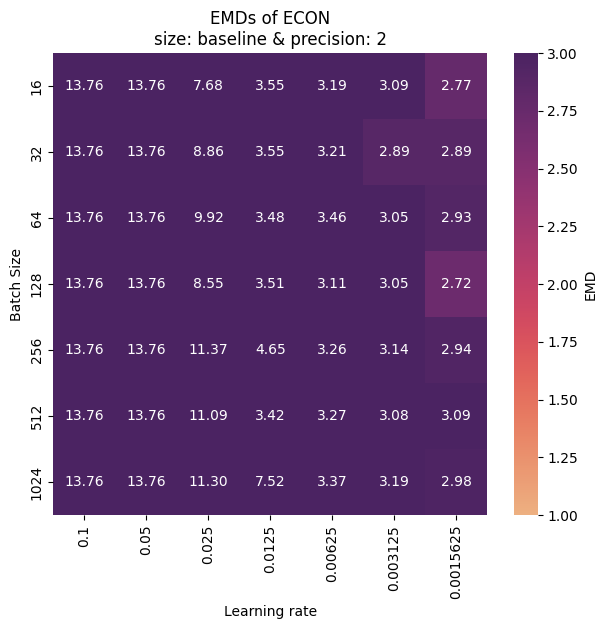

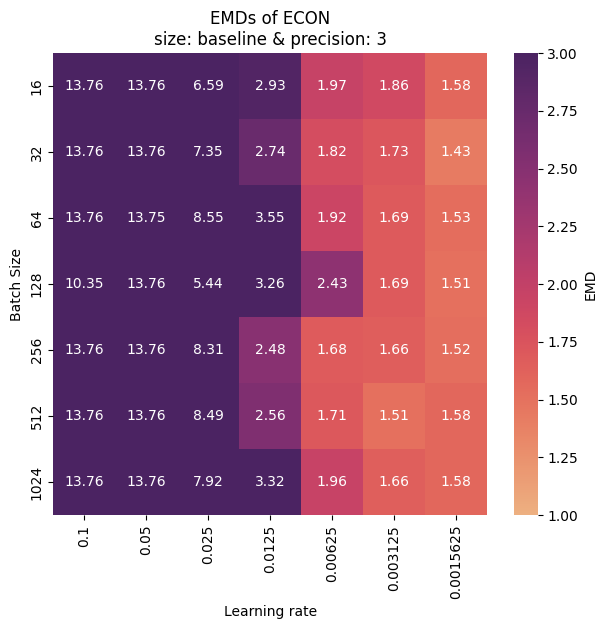

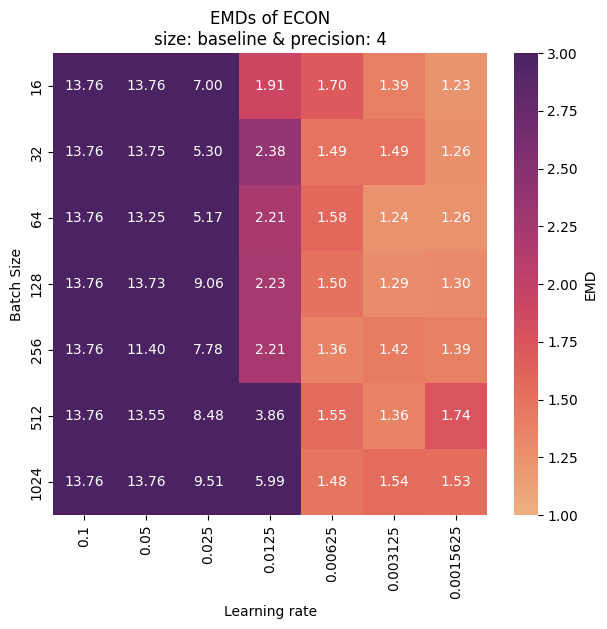

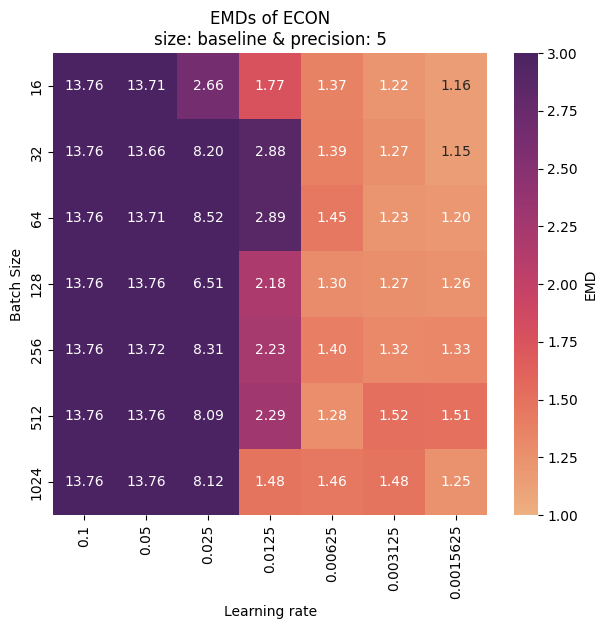

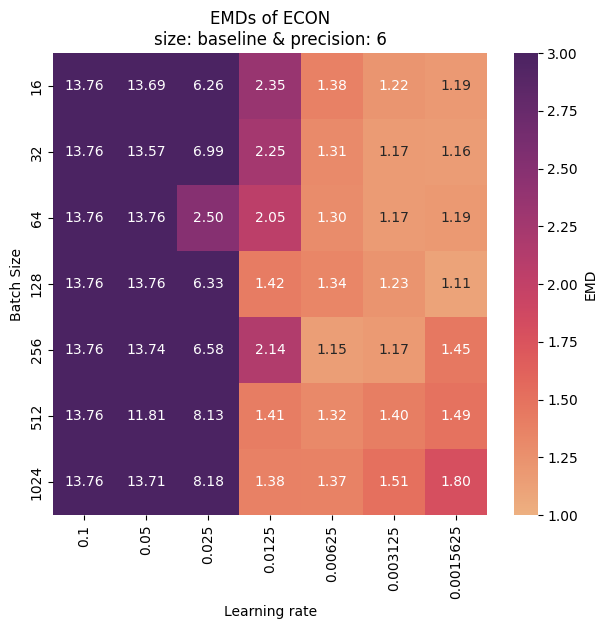

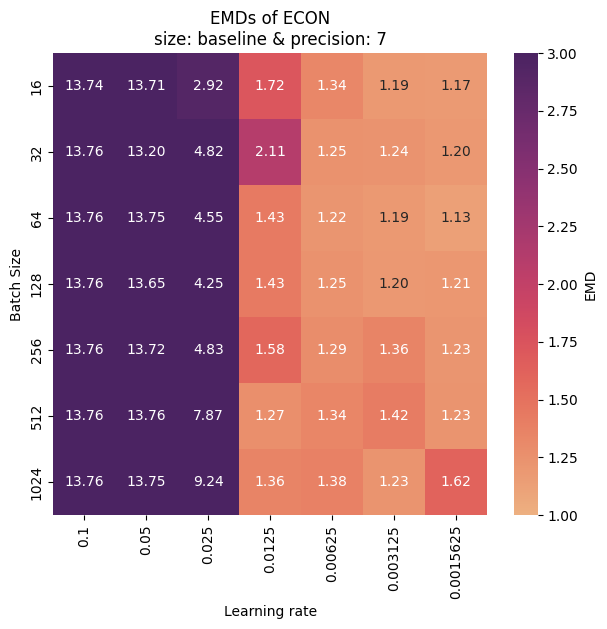

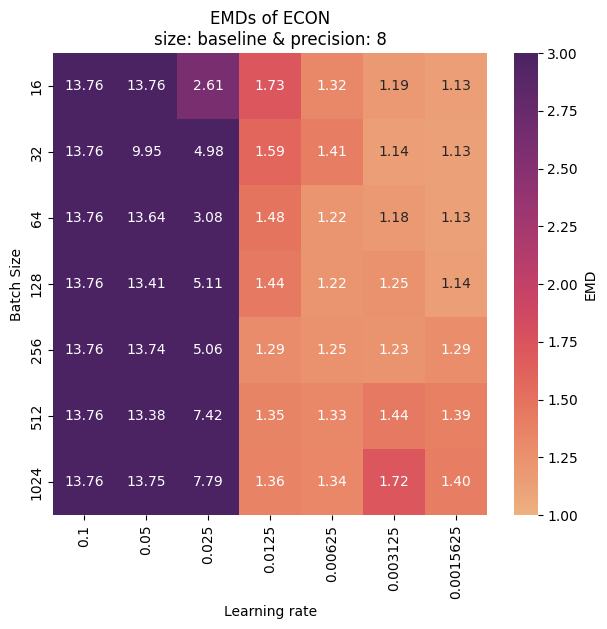

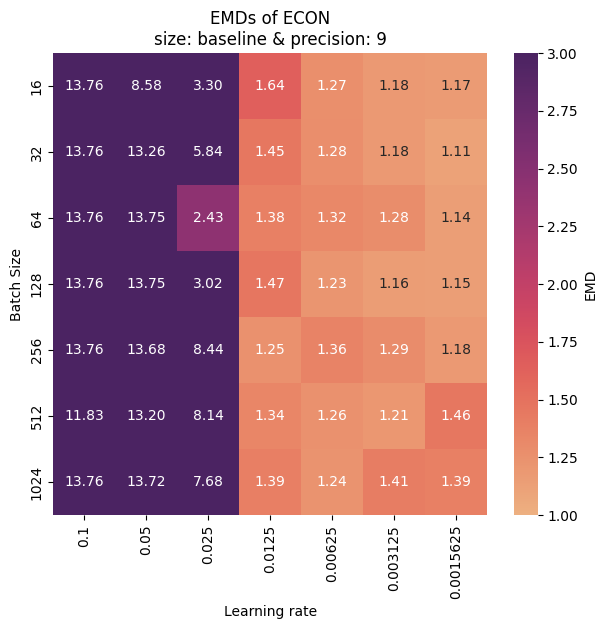

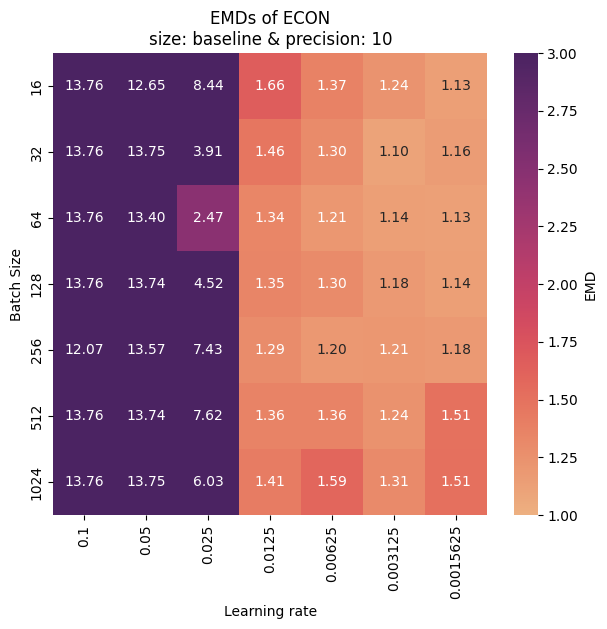

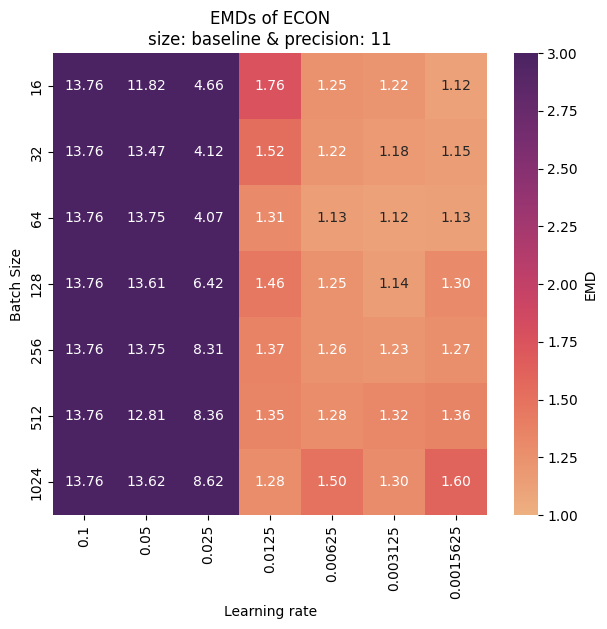

In [28]:
# plotting a heat map per layer
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_EMD, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            EMD_matrix[x, y] = mean_EMD
            
            
    EMD_matrix = pd.DataFrame(EMD_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(EMD_matrix, 
                    f'EMDs of ECON\nsize: {size} & precision: {p}', 
                    (1, 3),
                    'Learning rate',
                    'Batch Size',
                    'EMD',
                    cmap='flare')

Let's remove high learning rates from next analysis:

In [29]:
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]

In [30]:
emd_distribution = []
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_EMD, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            EMD_matrix[x, y] = mean_EMD
            emd_distribution.append({
                'precision': p, 
                'EMD': mean_EMD,
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })

In [31]:
emd_distribution_df = pd.DataFrame(emd_distribution)
emd_distribution_df = emd_distribution_df.sort_values(by='EMD', ascending=True)
emd_distribution_df.head(10)

,precision,EMD,batch_size,learning_rate
404,10,1.104643,32,0.003125
223,6,1.105781,128,0.0015625
356,9,1.114145,32,0.0015625
447,11,1.120972,16,0.0015625
460,11,1.123161,64,0.003125
412,10,1.126236,64,0.0015625
307,8,1.127017,32,0.0015625
461,11,1.127617,64,0.0015625
314,8,1.127975,64,0.0015625
265,7,1.132471,64,0.0015625


In [32]:
top_5_df = emd_distribution_df.loc[
        (emd_distribution_df.batch_size == '32') & (emd_distribution_df.learning_rate == '0.003125') |
        (emd_distribution_df.batch_size == '128') & (emd_distribution_df.learning_rate == '0.0015625') |
        (emd_distribution_df.batch_size == '32') & (emd_distribution_df.learning_rate == '0.0015625') |
        (emd_distribution_df.batch_size == '16') & (emd_distribution_df.learning_rate == '0.0015625') |
        (emd_distribution_df.batch_size == '64') & (emd_distribution_df.learning_rate == '0.003125')
    ]

top_5_df['bs_lr'] = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)

pyg.walk(top_5_df)

/tmp/ipykernel_2864895/1030508774.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_df['bs_lr'] = top_5_df[['batch_size', 'learning_rate']] \


Box(children=(HTML(value='<div id="ifr-pyg-4" style="height: auto">\n    <head>\n        <meta http-equiv="Con…

In [33]:
top_5_df = emd_distribution_df.loc[
    (emd_distribution_df.batch_size == '32') & (emd_distribution_df.precision == 10) |
    (emd_distribution_df.batch_size == '128') & (emd_distribution_df.precision == 6) |
    (emd_distribution_df.batch_size == '32') & (emd_distribution_df.precision == 9) |
    (emd_distribution_df.batch_size == '16') & (emd_distribution_df.precision == 11) |
    (emd_distribution_df.batch_size == '64') & (emd_distribution_df.precision == 11)
    ]

top_5_df = top_5_df.sort_values(by='learning_rate', ascending=True)

top_5_df['bs_p'] = top_5_df[['batch_size', 'precision']] \
        .apply(lambda row: f"{row.batch_size}, {row.precision}", axis=1)

pyg.walk(top_5_df)

Box(children=(HTML(value='<div id="ifr-pyg-5" style="height: auto">\n    <head>\n        <meta http-equiv="Con…

## Scientific Benchmark

Discard the extreme low precision because of its performance

In [34]:
precisions = [3, 4, 5, 6, 7, 8, 9, 10, 11]
noise_type = 'gaussian'

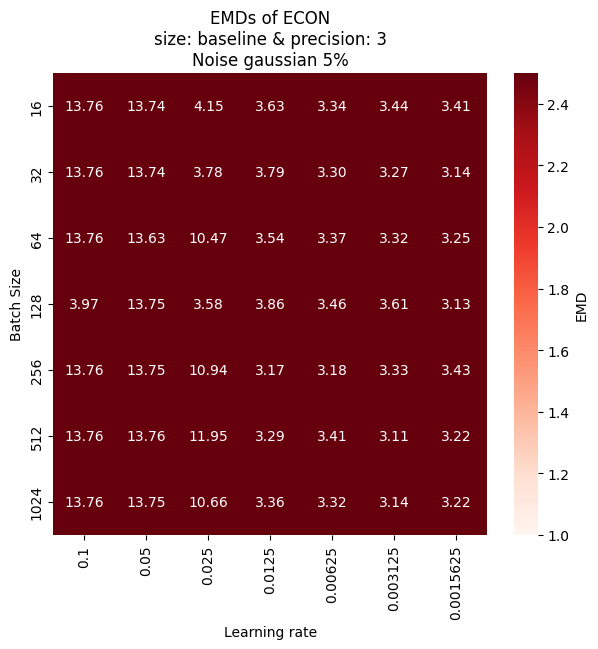

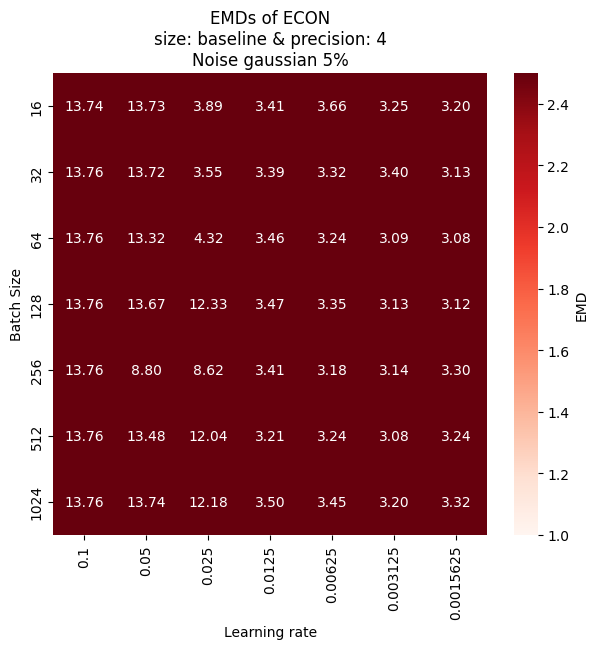

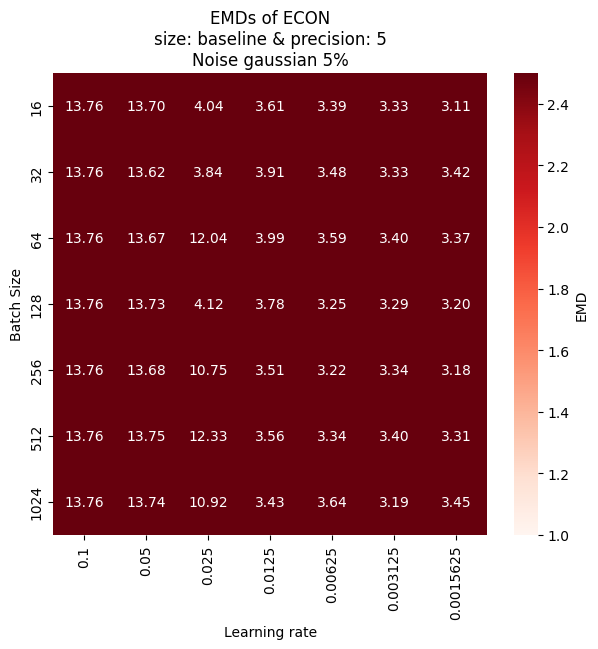

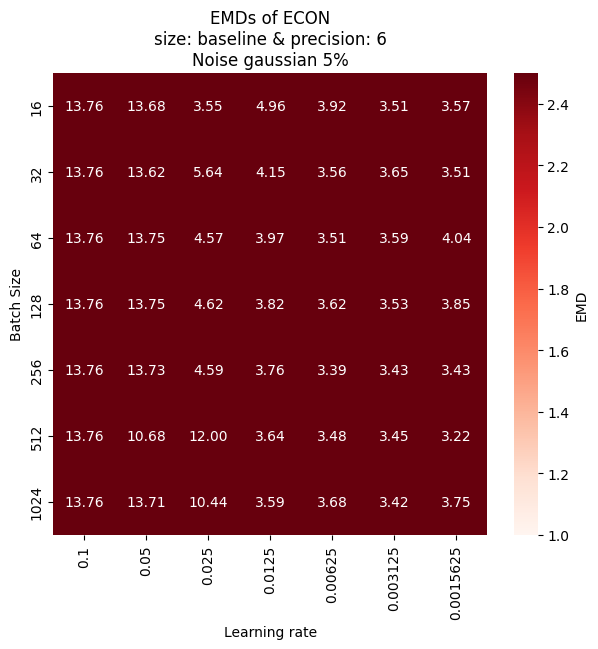

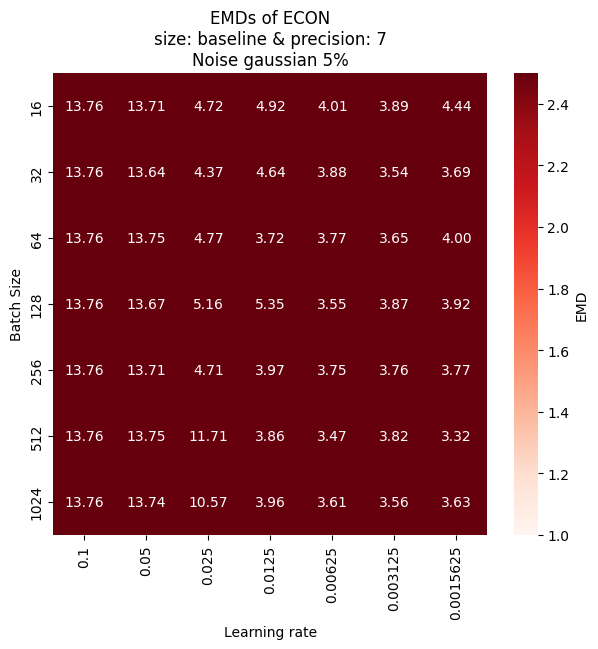

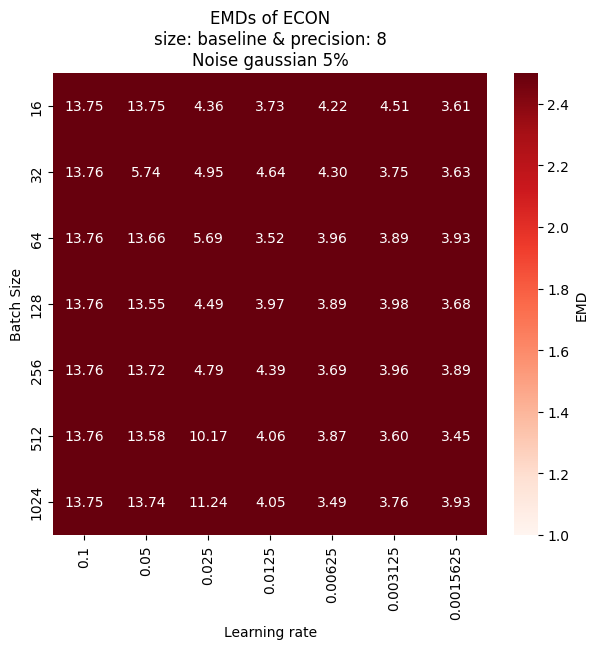

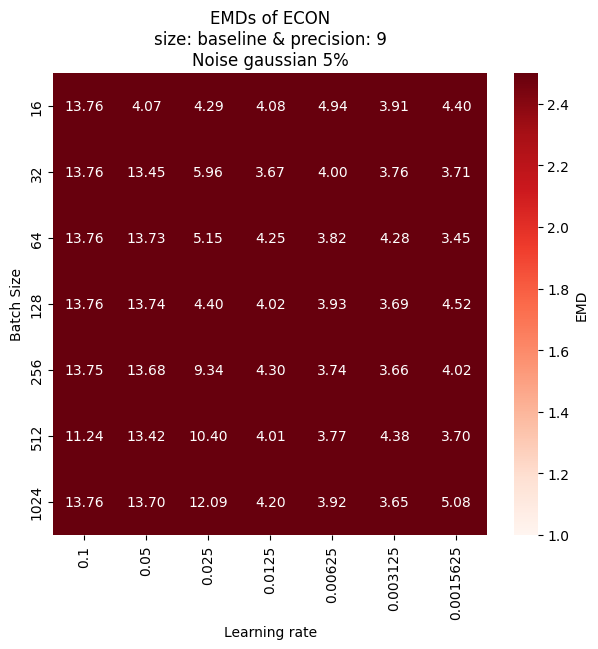

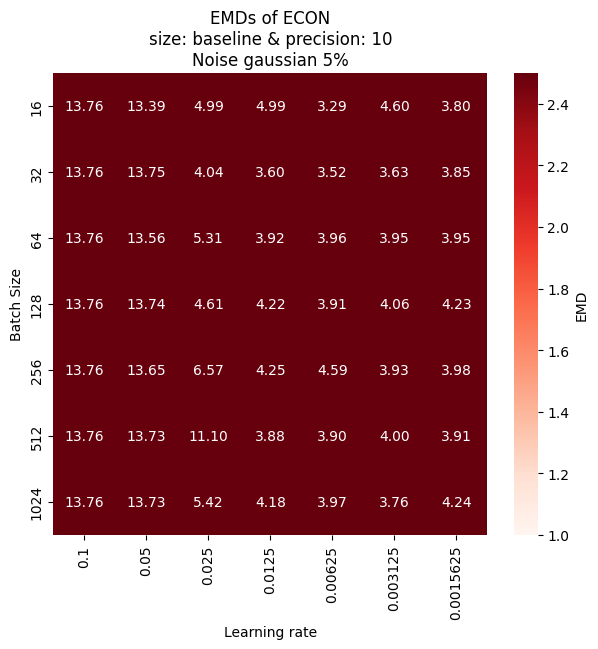

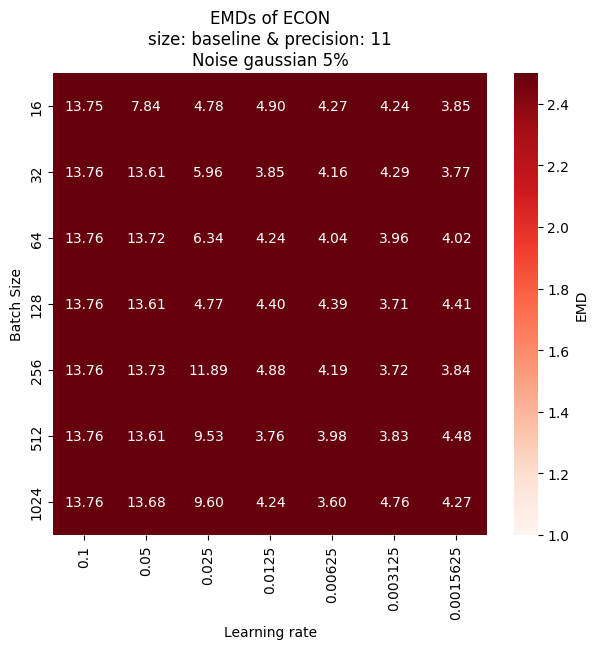

In [35]:
emd_distribution = []
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            # get teh noise values
            noise_emd_5 = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, 5)
            noise_emd_10 = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, 10)
            noise_emd_15 = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, 15)
            noise_emd_20 = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, 20)
            original_emd, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            
            # build the matrix for the heatmap
            EMD_matrix[x, y] = noise_emd_20
            
            # store the values for the plots
            emd_distribution.append({
                'precision': p, 
                'emd': original_emd,
                'type': 'original',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
                'loss': 0
            })
            emd_distribution.append({
                'precision': p, 
                'emd': noise_emd_5,
                'type': '5%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
                'loss': (noise_emd_5 - original_emd) * 100 / original_emd,
                'original_emd': original_emd
            })
            emd_distribution.append({
                'precision': p, 
                'emd': noise_emd_10,
                'type': '10%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
                'loss': (noise_emd_10 - original_emd) * 100 / original_emd,
                'original_emd': original_emd
            })
            emd_distribution.append({
                'precision': p, 
                'emd': noise_emd_15,
                'type': '15%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
                'loss': (noise_emd_15 - original_emd) * 100 / original_emd,
                'original_emd': original_emd
            })
            emd_distribution.append({
                'precision': p, 
                'emd': noise_emd_20,
                'type': '20%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
                'loss': (noise_emd_20 - original_emd) * 100 / original_emd,
                'original_emd': original_emd
            })
            
            
            
    # heat map of the EMD with noise as input per precision
    EMD_matrix = pd.DataFrame(EMD_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(EMD_matrix, 
                    f'EMDs of ECON\nsize: {size} & precision: {p}\n' \
                    f'Noise {noise_type} 5%', 
                    (1, 2.5),
                    'Learning rate',
                    'Batch Size',
                    'EMD',
                    cmap='Reds')
        

In [36]:
emd_distribution_df = pd.DataFrame(emd_distribution)
emd_distribution_df = emd_distribution_df.loc[emd_distribution_df.emd > 0]

In [37]:
noise = 5 # 5 10 15 20
top_noise_df = emd_distribution_df.loc[emd_distribution_df.type == f'{noise}%']
top_noise_df = top_noise_df.sort_values(by='original_emd', ascending=True)
top_noise_df.head(10)

,precision,emd,type,batch_size,learning_rate,loss,original_emd
1776,10,3.295514,5%,32,0.003125,198.332851,1.104643
871,6,2.092937,5%,128,0.0015625,89.272226,1.105781
1536,9,2.930733,5%,32,0.0015625,163.047696,1.114145
1991,11,3.225034,5%,16,0.0015625,187.699853,1.120972
2056,11,3.758025,5%,64,0.003125,234.593605,1.123161
1816,10,2.939933,5%,64,0.0015625,161.040547,1.126236
1291,8,2.892940,5%,32,0.0015625,156.690008,1.127017
2061,11,3.419863,5%,64,0.0015625,203.282393,1.127617
1326,8,2.684867,5%,64,0.0015625,138.025473,1.127975
1081,7,2.158104,5%,64,0.0015625,90.565959,1.132471


In [38]:
top_noise_df = top_noise_df.loc[
    (top_noise_df.batch_size == '32') & (top_noise_df.learning_rate == '0.003125') |
    (top_noise_df.batch_size == '128') & (top_noise_df.learning_rate == '0.0015625') |
    (top_noise_df.batch_size == '32') & (top_noise_df.learning_rate == '0.0015625') |
    (top_noise_df.batch_size == '16') & (top_noise_df.learning_rate == '0.0015625') |
    (top_noise_df.batch_size == '64') & (top_noise_df.learning_rate == '0.003125')
    ]

top_noise_df = top_noise_df.sort_values(by='precision', ascending=False)

top_noise_df['bs_lr'] = top_noise_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)

pyg.walk(top_noise_df)

Box(children=(HTML(value='<div id="ifr-pyg-6" style="height: auto">\n    <head>\n        <meta http-equiv="Con…

In [39]:
top_noise_df = top_noise_df.loc[
    (top_noise_df.batch_size == '32') & (top_noise_df.precision == 10) |
    (top_noise_df.batch_size == '128') & (top_noise_df.precision == 6) |
    (top_noise_df.batch_size == '32') & (top_noise_df.precision == 9) |
    (top_noise_df.batch_size == '16') & (top_noise_df.precision == 11) |
    (top_noise_df.batch_size == '64') & (top_noise_df.precision == 11)
    ]

top_noise_df = top_noise_df.sort_values(by='learning_rate', ascending=True)

top_noise_df['bs_p'] = top_noise_df[['batch_size', 'precision']] \
        .apply(lambda row: f"{row.batch_size}, {row.precision}", axis=1)

pyg.walk(top_noise_df)

Box(children=(HTML(value='<div id="ifr-pyg-7" style="height: auto">\n    <head>\n        <meta http-equiv="Con…

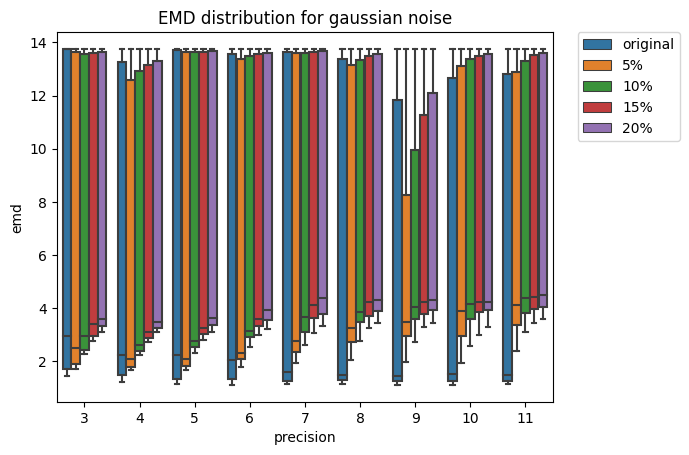

In [40]:
sns.boxplot(data=emd_distribution_df, 
            x='precision', 
            y='emd',
            hue='type',
            showfliers=False)

plt.title(f'EMD distribution for {noise_type} noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

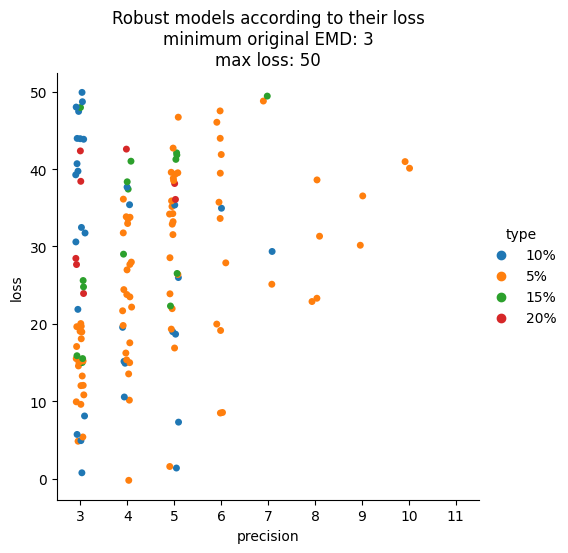

In [41]:
MAX_LOSS = 50
MAX_EMD = 3
# filter the entries 
robust_df = emd_distribution_df.sort_values(by=['loss', 'original_emd'], ascending=[True, True])
robust_df = robust_df.drop(robust_df[robust_df.type == 'original'].index)
robust_df = robust_df.drop(robust_df[(robust_df.loss < -0.5) | (robust_df.loss > MAX_LOSS)].index)
robust_df = robust_df.drop(robust_df[robust_df.original_emd > MAX_EMD].index)

sns.catplot(robust_df, y='loss', x='precision', hue='type', order=precisions)
plt.title(f'Robust models according to their loss\n' \
          f'minimum original EMD: {MAX_EMD}\n' \
          f'max loss: {MAX_LOSS}')
plt.show()

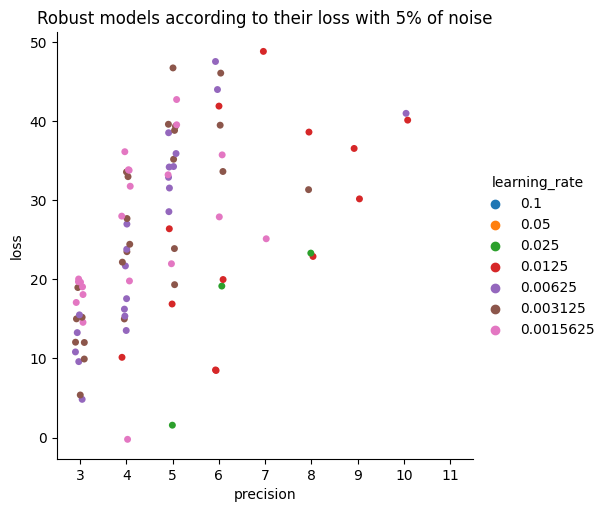

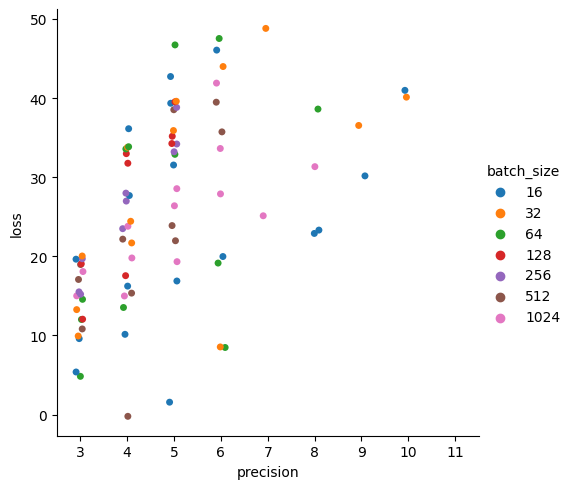

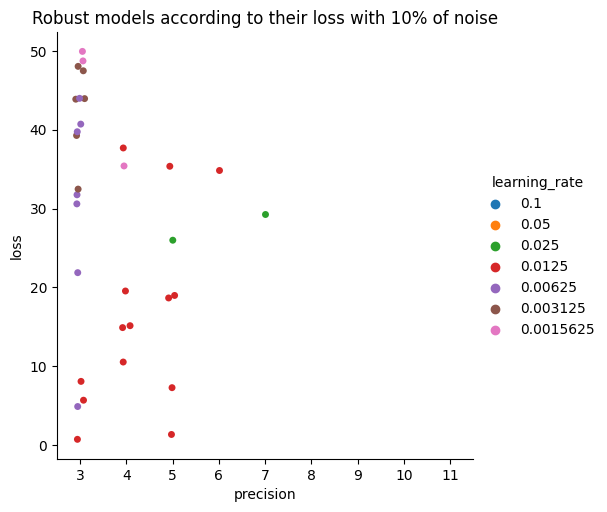

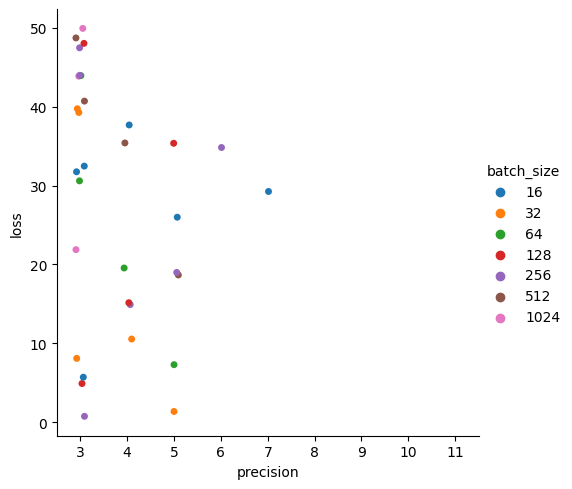

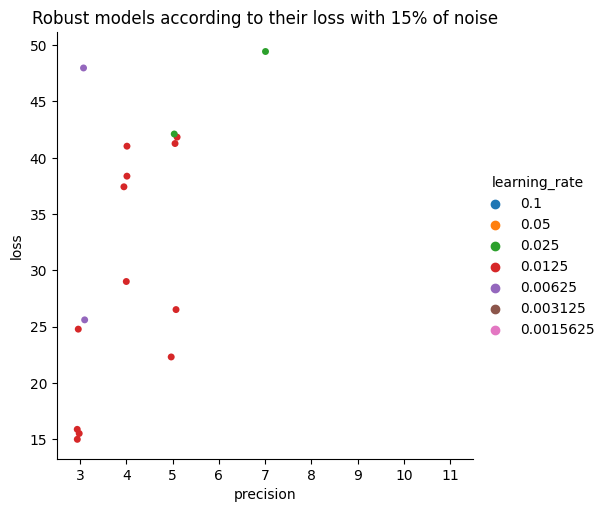

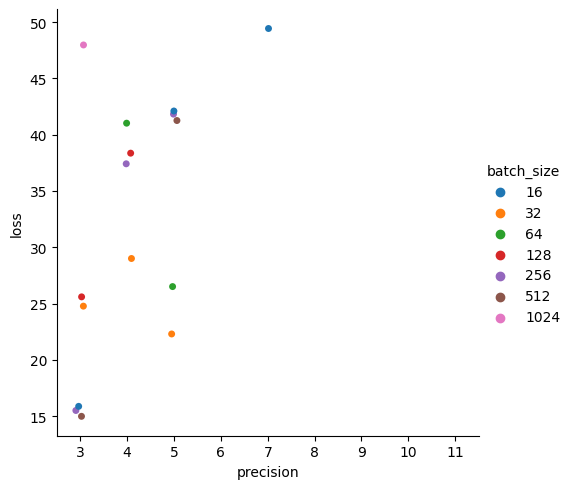

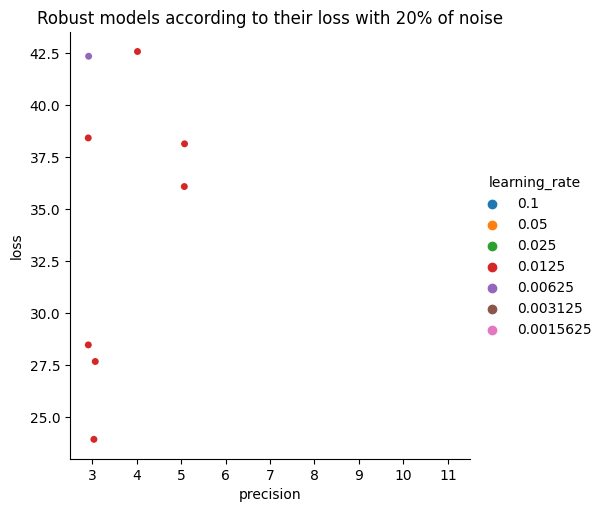

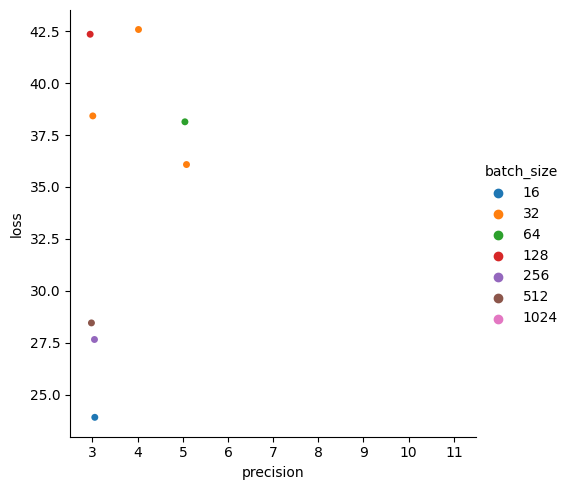

In [42]:
noise_levels = [5, 10, 15, 20]
for noise in noise_levels:
    # Check the most robust models per noise
    df = robust_df.drop(robust_df[robust_df.type != f'{noise}%'].index)
    df = df.reset_index()
    
    sns.catplot(df, 
                x='precision', 
                y='loss', 
                hue='learning_rate', 
                order=precisions, 
                hue_order=[str(x) for x in learning_rates])
    plt.title(f'Robust models according to their loss with {noise}% of noise')
    sns.catplot(df, 
                x='precision', 
                y='loss', 
                hue='batch_size', 
                order=precisions, 
                hue_order=[str(x) for x in batch_sizes])
    plt.show()
    # print(df[['original_emd', 'loss', 'batch_size', 'learning_rate', 'precision']].head(10))
    # print(df[['original_emd', 'loss', 'batch_size', 'learning_rate', 'precision']].tail(10))
    # df.to_csv(f"./out_ECON_{noise}_{noise_type}.csv")

In [43]:
noise = 5 # 5 10 15 20
top_noise_df = robust_df.loc[robust_df.type == f'{noise}%']
top_noise_df = top_noise_df.sort_values(by='loss', ascending=True)
top_noise_df = top_noise_df.reset_index()
top_noise_df.head(5)

,index,precision,emd,type,batch_size,learning_rate,loss,original_emd
0,451,4,1.740360,5%,512,0.0015625,-0.230485,1.744381
1,501,5,2.696499,5%,16,0.025,1.557043,2.655157
2,91,3,2.011639,5%,64,0.00625,4.823929,1.919065
3,26,3,1.960850,5%,16,0.003125,5.372305,1.860878
4,821,6,2.223114,5%,64,0.0125,8.469763,2.049524


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

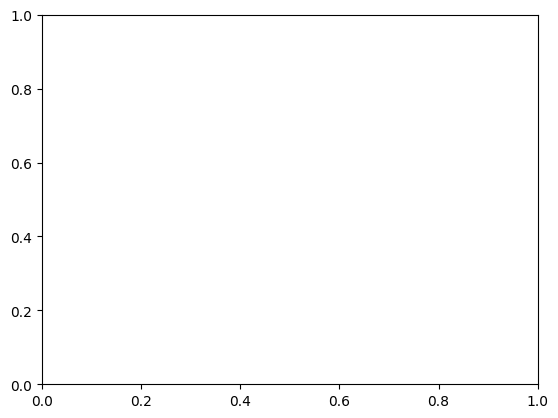

In [44]:
top_noise_df = top_noise_df.loc[
        (top_noise_df.batch_size == '512') & (top_noise_df.learning_rate == '0.0015625') |
        (top_noise_df.batch_size == '16') & (top_noise_df.learning_rate == '0.003125') |
        (top_noise_df.batch_size == '64') & (top_noise_df.learning_rate == '0.00625') |
        (top_noise_df.batch_size == '16') & (top_noise_df.learning_rate == '0.0125') |
        (top_noise_df.batch_size == '32') & (top_noise_df.learning_rate == '0.0125') 
        
    ]
hue = top_noise_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_noise_df, x='precision', y='emd', hue=hue)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title(f"EMD of the best models at different precisions with {noise}% of noise")
plt.show()

# Jet Tagger (MLP)
The full precision model achieve 76% of accuracy.

In [ ]:
DATA_PATH="/home/jovyan/checkpoint/"    
DATASET_DIR="../../data/JTAG"
DATASET_FILE=DATASET_DIR + "/processed_dataset.h5"

In [ ]:
def get_data_module(batch_size, num_workers=12):
    '''
    Method used to get the data modules used during the tests
    '''
    data_module = JetDataModule(
        data_dir=DATASET_DIR,
        data_file=os.path.join(DATASET_DIR, DATASET_FILE),
        batch_size=batch_size,
        num_workers=num_workers)
    
    # checek if we have processed the data
    if not os.path.exists(os.path.join(DATASET_DIR, DATASET_FILE)):
        print('Processing the data...')
        data_module.process_data(save=True)

    data_module.setup(0)
    return data_module


def load_model(batch_size, learning_rate, precision):
    '''
    Method used to get the model and the relative accuracy
    '''
    accuracy, idx = get_model_index_and_relative_accuracy(batch_size, learning_rate, precision)
    model_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/JTAG_{precision}b/net_{idx}_best.pkl'
    
    # load the model
    model = JetTagger(
        quantize=(precision < 32),
        precision=[
            precision,
            precision,
            precision+3
        ],
        learning_rate=learning_rate,
    )
    
    # to set the map location
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model(torch.randn((16, 16)))  # Update tensor shapes 
    model_param = torch.load(model_path, map_location=device)
    model.load_state_dict(model_param['state_dict'])
    
    return model, accuracy


def get_model_index_and_relative_accuracy(batch_size, learning_rate, precision, num_tests=5):
    '''
    Return the average EMDs achieved by the model and the index of best experiment
    '''
    performances = []
    max_acc = 0
    max_acc_index = 0
    for i in range (1, num_tests+1):
        file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                    f'JTAG_{precision}b/accuracy_{i}.txt'
        try:
            jtag_file = open(file_path)
            jtag_text = jtag_file.read()
            accuracy = ast.literal_eval(jtag_text)
            accuracy = accuracy[0]['test_acc']
            performances.append(accuracy)
            if accuracy >= max_acc:
                max_acc = accuracy
                max_acc_index = i
            jtag_file.close()
        except Exception as e:
            # warnings.warn("Warning: " + file_path + " not found!")
            continue
        
    if len(performances) == 0:
        # warnings.warn(f"Attention: There is no accuracy value for the model: " \
        #               f"bs{batch_size}_lr{learning_rate}/JTAG_{precision}b")
        return
    
    return mean(performances), max_acc_index

## Accuracy results

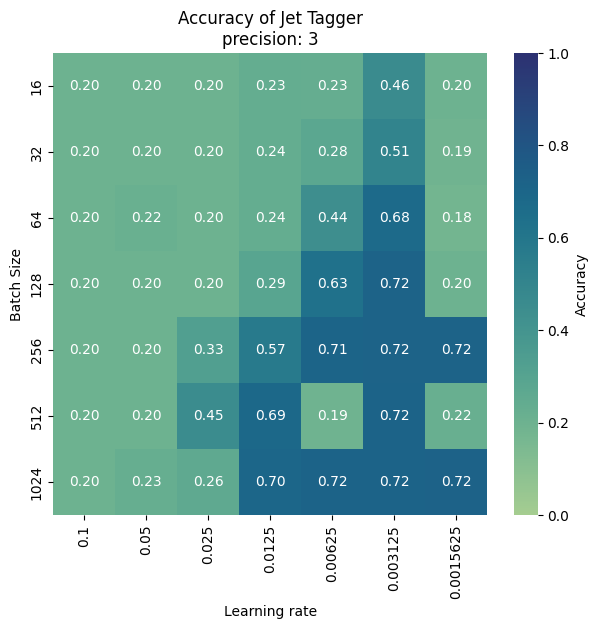

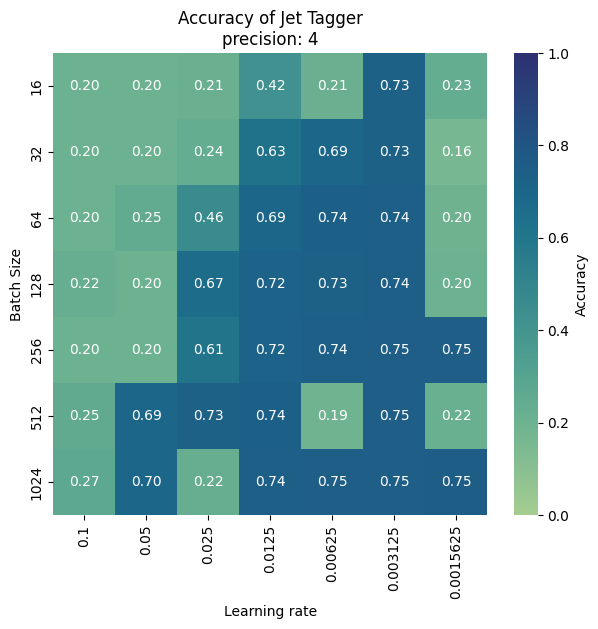

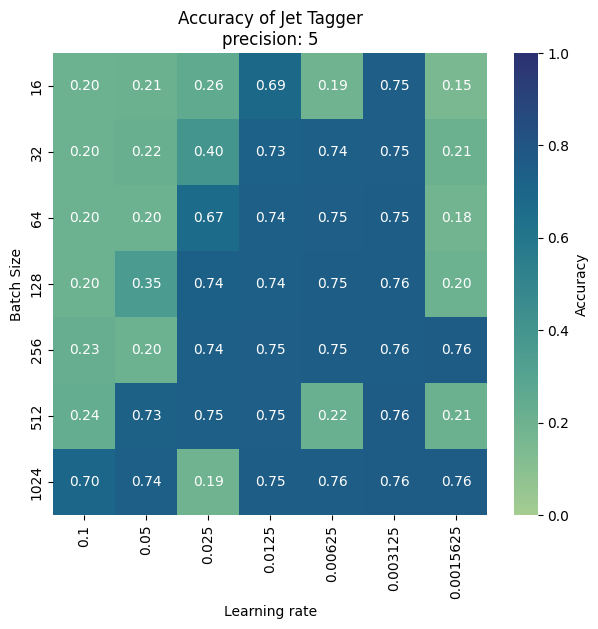

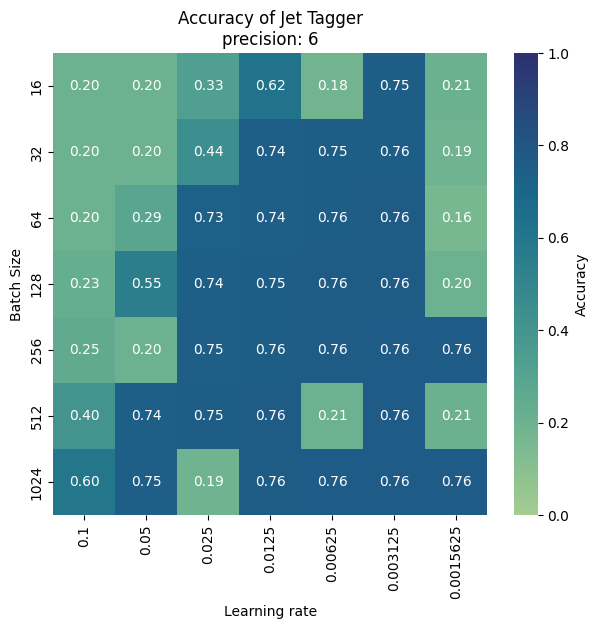

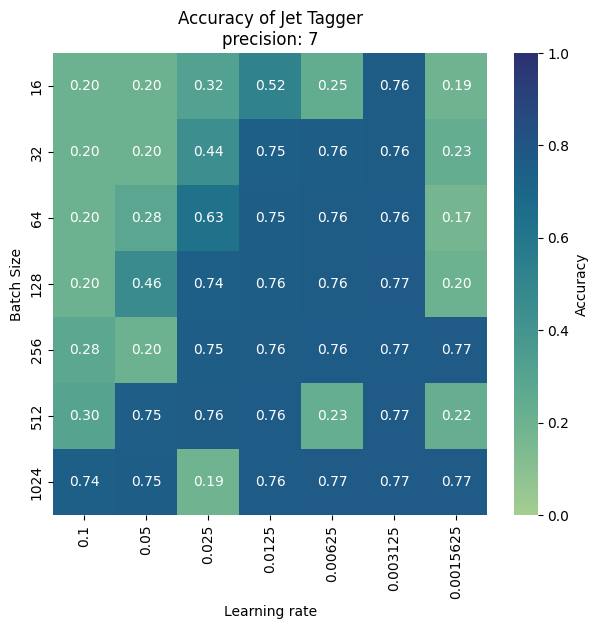

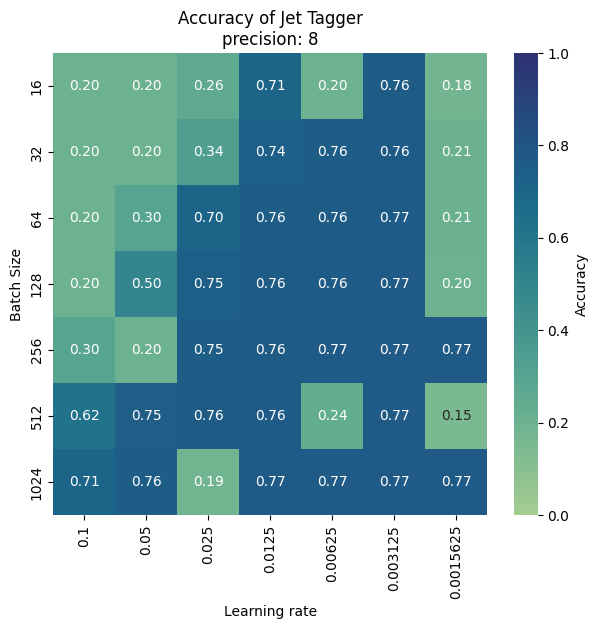

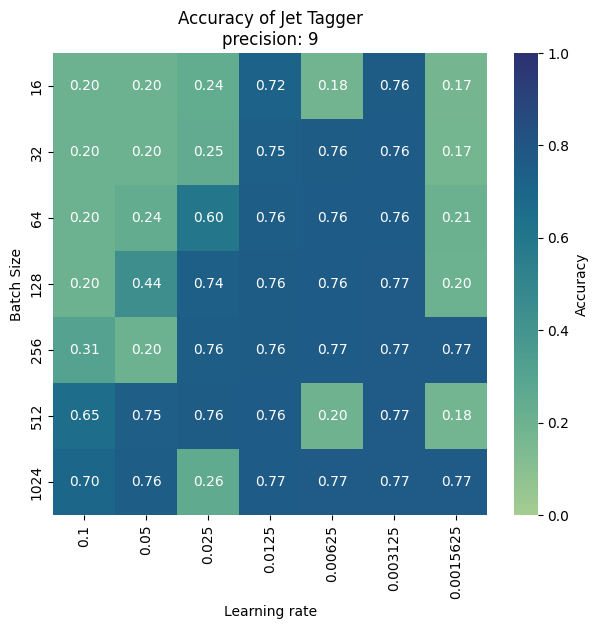

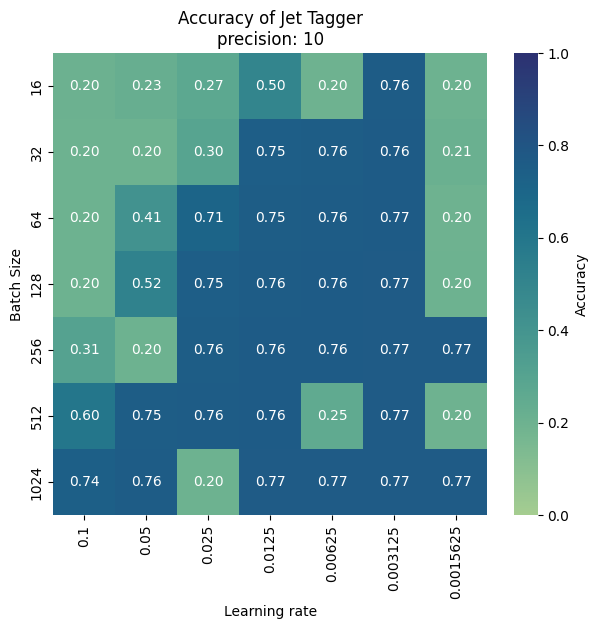

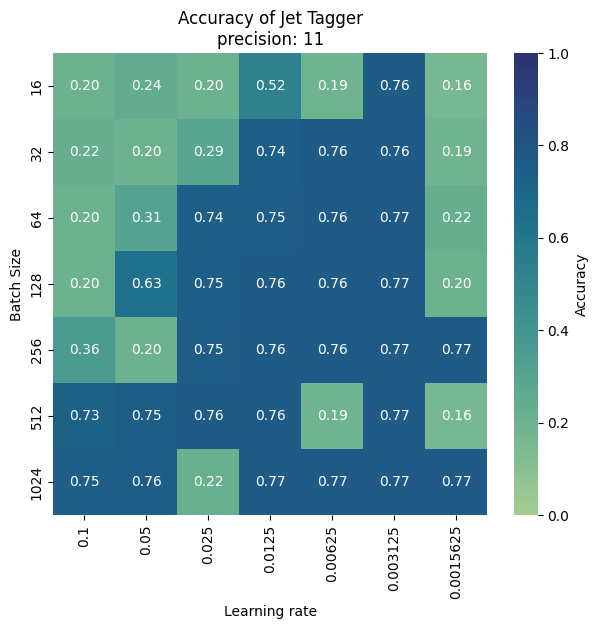

In [ ]:
# plotting a heat map per layer
for p in precisions:
    accuracy_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_acc, _ = get_model_index_and_relative_accuracy(bs, lr, p)
            accuracy_matrix[x, y] = mean_acc
            
            
    accuracy_matrix = pd.DataFrame(accuracy_matrix, 
                                   index=batch_sizes, 
                                   columns=learning_rates)
    
    plot_2d_heatmap(accuracy_matrix, 
                    f'Accuracy of Jet Tagger\nprecision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Accuracy',
                    cmap='crest')

In [ ]:
acc_distribution = []
for p in precisions:
    acc_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_acc, _ = get_model_index_and_relative_accuracy(bs, lr, p)
            acc_matrix[x, y] = mean_acc
            acc_distribution.append({
                'precision': p, 
                'accuracy': mean_acc,
                'batch_size': str(bs),
                'learning_rate': str(lr)
            })

In [ ]:
acc_distribution_df = pd.DataFrame(acc_distribution)
acc_distribution_df = acc_distribution_df.sort_values(by='accuracy', ascending=False)
acc_distribution_df.head(10)

,precision,accuracy,batch_size,learning_rate
279,11,0.768954,1024,0.0015625
234,10,0.768859,256,0.0015625
199,9,0.768732,256,0.0015625
174,8,0.768623,1024,0.0015625
208,9,0.768571,1024,0.003125
209,9,0.768535,1024,0.0015625
269,11,0.768075,256,0.0015625
173,8,0.767931,1024,0.003125
244,10,0.767913,1024,0.0015625
242,10,0.767898,1024,0.00625


,precision,accuracy,batch_size,learning_rate
440,11,0.768954,1024,0.0015625
377,10,0.768859,256,0.0015625
328,9,0.768732,256,0.0015625
293,8,0.768623,1024,0.0015625
341,9,0.768571,1024,0.003125
342,9,0.768535,1024,0.0015625
426,11,0.768075,256,0.0015625
292,8,0.767931,1024,0.003125
391,10,0.767913,1024,0.0015625
389,10,0.767898,1024,0.00625


,precision,accuracy,batch_size,learning_rate
440,11,0.768954,1024,0.0015625
377,10,0.768859,256,0.0015625
328,9,0.768732,256,0.0015625
293,8,0.768623,1024,0.0015625
341,9,0.768571,1024,0.003125
342,9,0.768535,1024,0.0015625
426,11,0.768075,256,0.0015625
292,8,0.767931,1024,0.003125
391,10,0.767913,1024,0.0015625
389,10,0.767898,1024,0.00625


let's focus on the top models:

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

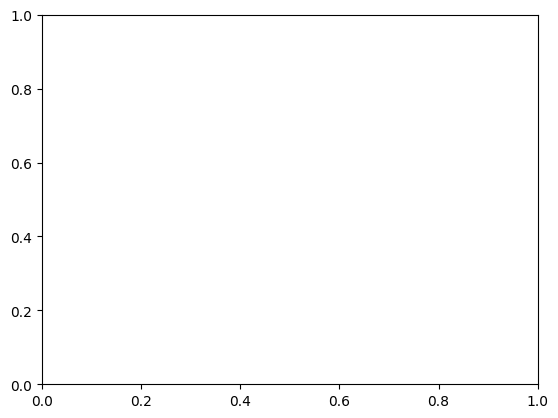

In [ ]:
top_5_df = acc_distribution_df.loc[
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.learning_rate == '0.0015625') |
    (acc_distribution_df.batch_size == '256') & (acc_distribution_df.learning_rate == '0.0015625') |
    (acc_distribution_df.batch_size == '256') & (acc_distribution_df.learning_rate == '0.0015625') |
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.learning_rate == '0.0015625') |
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.learning_rate == '0.003125')
    ]

hue = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_df, x='precision', y='accuracy', hue=hue)
plt.title("Accuracy of the best models at different precisions")
plt.show()

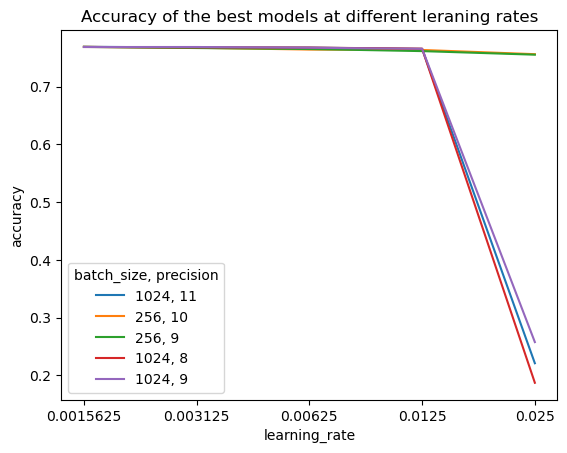

In [ ]:
top_5_df = acc_distribution_df.loc[
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.precision == 11) |
    (acc_distribution_df.batch_size == '256') & (acc_distribution_df.precision == 10) |
    (acc_distribution_df.batch_size == '256') & (acc_distribution_df.precision == 9) |
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.precision == 8) |
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.precision == 9)
    ]

top_5_df = top_5_df.sort_values(by='learning_rate', ascending=True)

hue = top_5_df[['batch_size', 'precision']] \
        .apply(lambda row: f"{row.batch_size}, {row.precision}", axis=1)
hue.name = 'batch_size, precision'

sns.lineplot(top_5_df, x='learning_rate', y='accuracy', hue=hue)
plt.title("Accuracy of the best models at different leraning rates")
plt.show()

## Scinetific Benchmark

In [ ]:
def get_accuracy_with_noise(batch_size, learning_rate, precision, noise_type, percentage):
    '''
    Return the accuracy achieved by the Model with a certain level of noise
    '''

    file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                f'JTAG_{precision}b/accuracy_{noise_type}_{percentage}.txt'
    noise_acc = -1
    try:
        acc_file = open(file_path)
        acc_text = acc_file.read()
        acc = ast.literal_eval(acc_text)
        noise_acc = acc[0]['test_acc']
        acc_file.close()
    except Exception as e:
        # warnings.warn("Warning: " + file_path + " not found!")
        return 0
    return noise_acc

In [ ]:
precisions = [4, 5, 6, 7, 8, 9, 10, 11]
noise_type = 'gaussian'

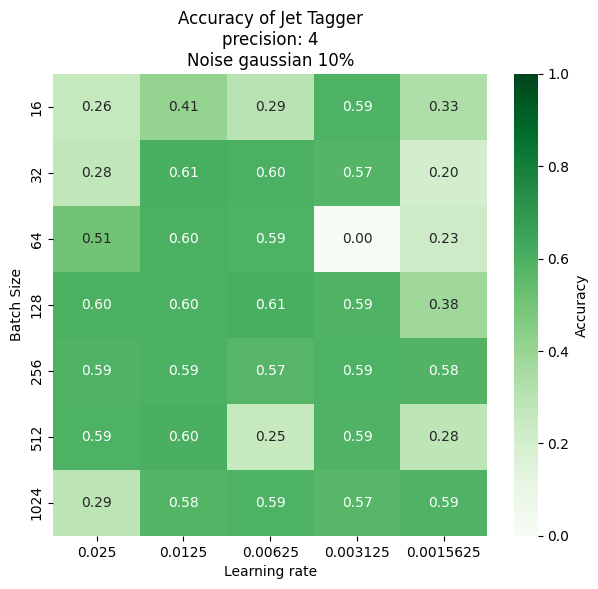

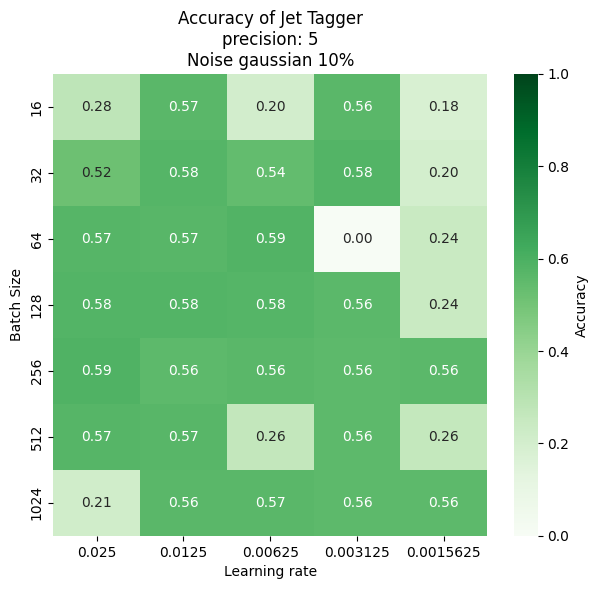

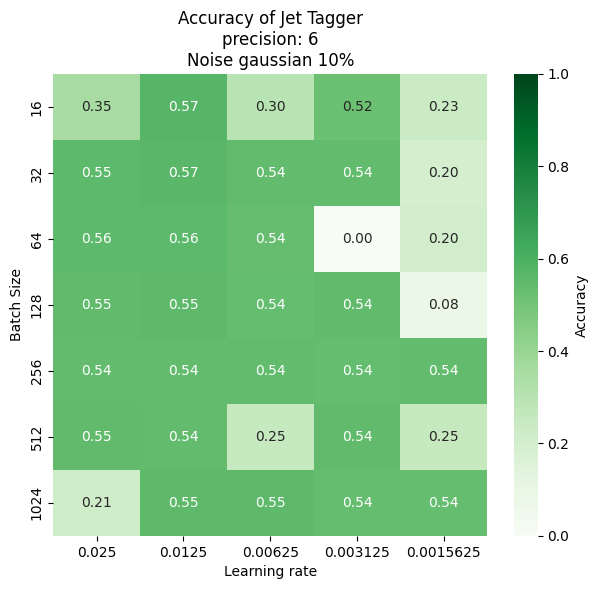

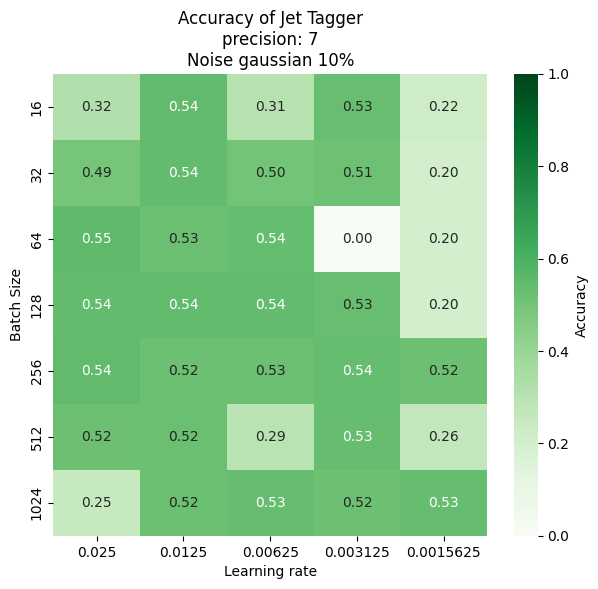

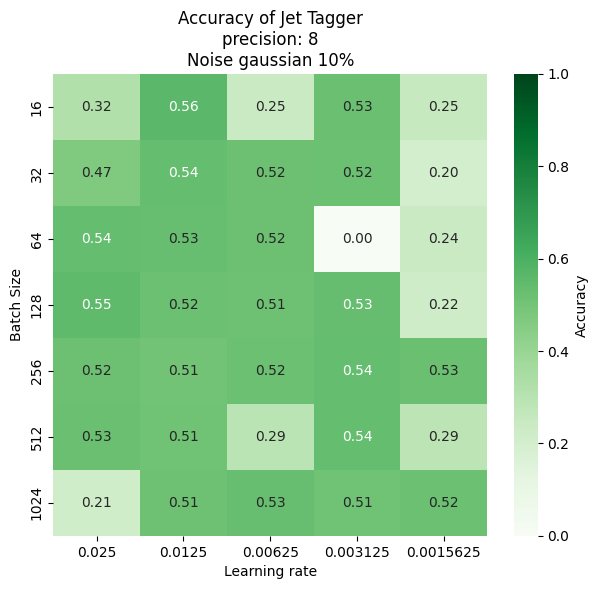

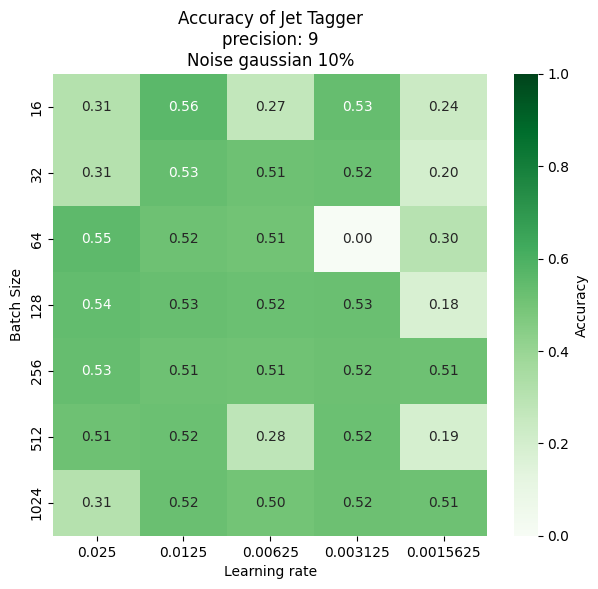

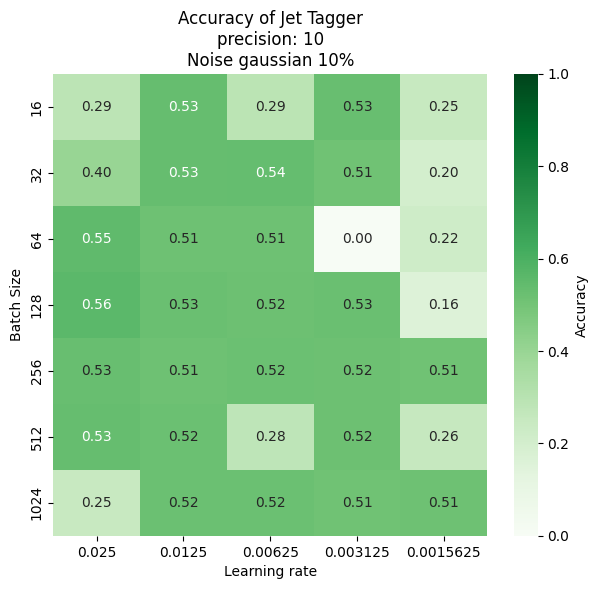

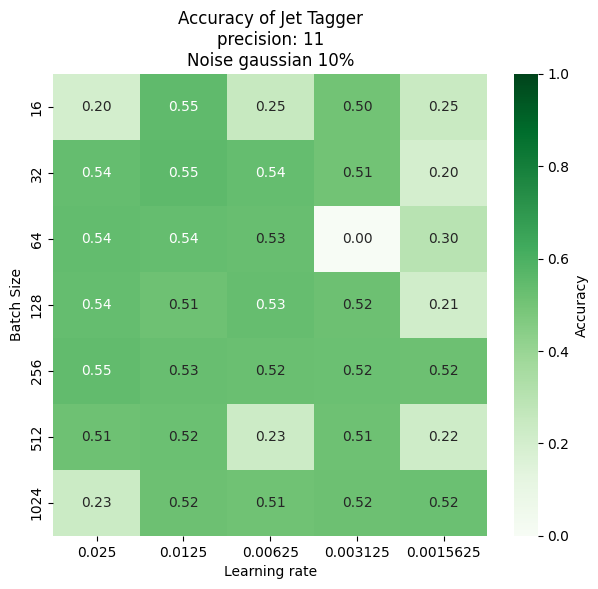

In [ ]:
acc_distribution = []
for p in precisions:
    acc_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            # get teh noise values
            noise_acc_20 = get_accuracy_with_noise(bs, lr, p, noise_type, 20)
            noise_acc_15 = get_accuracy_with_noise(bs, lr, p, noise_type, 15)
            noise_acc_10 = get_accuracy_with_noise(bs, lr, p, noise_type, 10)
            noise_acc_5 = get_accuracy_with_noise(bs, lr, p, noise_type, 5)
            original_acc, _ = get_model_index_and_relative_accuracy(bs, lr, p)
            
            # build the matrix for the heatmap
            acc_matrix[x, y] = noise_acc_20
            
            # store the values for the plots
            acc_distribution.append({
                'precision': p, 
                'accuracy': original_acc,
                'type': 'original',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': 0
            })
            acc_distribution.append({
                'precision': p, 
                'accuracy': noise_acc_5,
                'type': '5%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (original_acc - noise_acc_5) * 100 / original_acc,
                'original_acc': original_acc
            })
            acc_distribution.append({
                'precision': p, 
                'accuracy': noise_acc_10,
                'type': '10%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (original_acc - noise_acc_10) * 100 / original_acc,
                'original_acc': original_acc
            })
            acc_distribution.append({
                'precision': p, 
                'accuracy': noise_acc_15,
                'type': '15%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (original_acc - noise_acc_15) * 100 / original_acc,
                'original_acc': original_acc
            })
            acc_distribution.append({
                'precision': p, 
                'accuracy': noise_acc_20,
                'type': '20%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (original_acc - noise_acc_20) * 100 / original_acc,
                'original_acc': original_acc
            })
            
    # heat map of the accuracy with noise as input per precision
    acc_matrix = pd.DataFrame(acc_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(acc_matrix, 
                    f'Accuracy of Jet Tagger\nprecision: {p}\n' \
                    f'Noise {noise_type} 10%', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Accuracy')
        

In [ ]:
acc_distribution_df = pd.DataFrame(acc_distribution)
acc_distribution_df = acc_distribution_df.loc[acc_distribution_df.loss > -0.5]

In [ ]:
noise = 5 # 5 10 15 20
top_noise_df = acc_distribution_df.loc[acc_distribution_df.type == f'{noise}%']
top_noise_df = top_noise_df.sort_values(by='original_acc', ascending=False)
top_noise_df.head(10)

,precision,accuracy,type,batch_size,learning_rate,loss,original_acc
1396,11,0.727083,5%,1024,0.0015625,5.445168,0.768954
1171,10,0.725321,5%,256,0.0015625,5.662720,0.768859
996,9,0.723229,5%,256,0.0015625,5.919164,0.768732
871,8,0.728612,5%,1024,0.0015625,5.205419,0.768623
1041,9,0.726721,5%,1024,0.003125,5.445175,0.768571
1046,9,0.724275,5%,1024,0.0015625,5.759008,0.768535
1346,11,0.726504,5%,256,0.0015625,5.412345,0.768075
866,8,0.726375,5%,1024,0.003125,5.411406,0.767931
1221,10,0.727500,5%,1024,0.0015625,5.262743,0.767913
1211,10,0.725217,5%,1024,0.00625,5.558240,0.767898


Let's see how the previous top 5 models perform with noise:

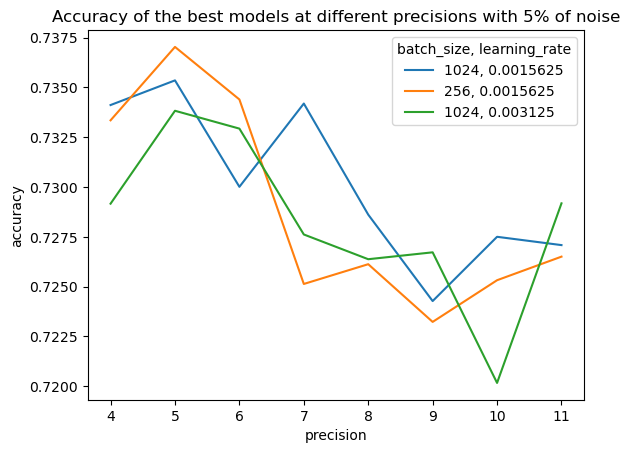

In [ ]:
top_noise_df = top_noise_df.loc[
        (top_noise_df.batch_size == '1024') & (top_noise_df.learning_rate == '0.0015625') |
        (top_noise_df.batch_size == '256') & (top_noise_df.learning_rate == '0.0015625') |
        (top_noise_df.batch_size == '256') & (top_noise_df.learning_rate == '0.0015625') |
        (top_noise_df.batch_size == '1024') & (top_noise_df.learning_rate == '0.0015625') |
        (top_noise_df.batch_size == '1024') & (top_noise_df.learning_rate == '0.003125')
    ]
hue = top_noise_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_noise_df, x='precision', y='accuracy', hue=hue)
plt.title("Accuracy of the best models at different precisions with 5% of noise")
plt.show()

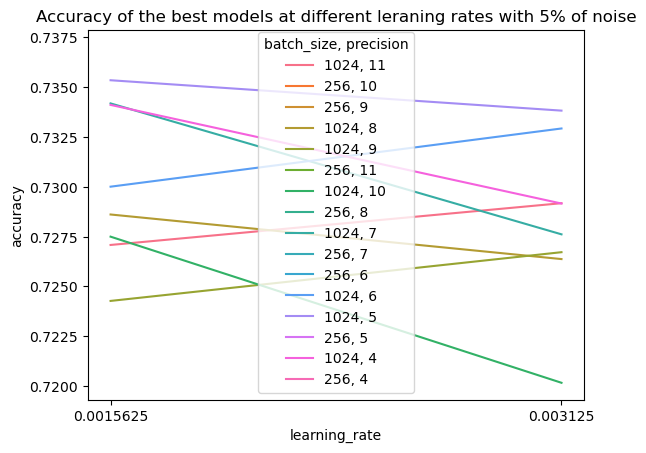

In [ ]:
top_5_noise_df = top_noise_df.loc[
        (top_noise_df.batch_size == '1024') & (top_noise_df.precision == 11) |
        (top_noise_df.batch_size == '256') & (top_noise_df.precision == 10) |
        (top_noise_df.batch_size == '256') & (top_noise_df.precision == 9) |
        (top_noise_df.batch_size == '1024') & (top_noise_df.precision == 8) |
        (top_noise_df.batch_size == '1024') & (top_noise_df.precision == 9)
    ]
#top_5_noise_df = top_5_noise_df.sort_values(by='learning_rate', ascending=True)

hue = top_noise_df[['batch_size', 'precision']] \
        .apply(lambda row: f"{row.batch_size}, {row.precision}", axis=1)
hue.name = 'batch_size, precision'

sns.lineplot(top_noise_df, x='learning_rate', y='accuracy', hue=hue)
plt.title("Accuracy of the best models at different leraning rates with 5% of noise")
plt.show()

Let's look at the distribution of the accuracies per noise:

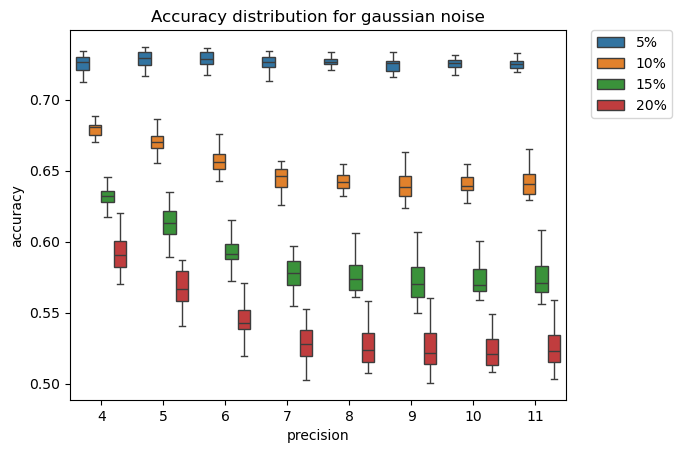

In [ ]:
sns.boxplot(data=acc_distribution_df, 
            x='precision', 
            y='accuracy',
            hue='type',
            hue_order=['5%', '10%', '15%', '20%'],
            showfliers=False)

plt.title(f'Accuracy distribution for {noise_type} noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Now we can focus only to those models that are more robust to noise.

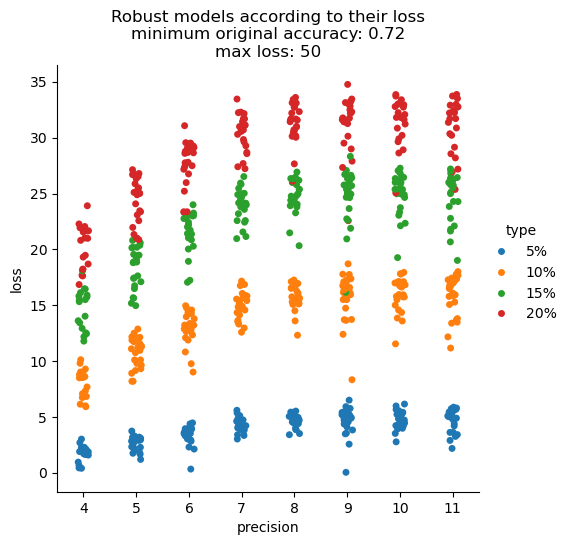

In [ ]:
MAX_LOSS = 50
MIN_ACCURACY = 0.72
# filter the entries 
robust_df = acc_distribution_df.sort_values(by=['loss', 'original_acc'], ascending=[True, False])
robust_df = robust_df.drop(robust_df[robust_df.type == 'original'].index)
robust_df = robust_df.drop(robust_df[(robust_df.loss < -1) | (robust_df.loss > MAX_LOSS)].index)
robust_df = robust_df.drop(robust_df[robust_df.original_acc < MIN_ACCURACY].index)

sns.catplot(robust_df, y='loss', x='precision', hue='type', order=precisions)
plt.title(f'Robust models according to their loss\n' \
          f'minimum original accuracy: {MIN_ACCURACY}\n' \
          f'max loss: {MAX_LOSS}')
plt.show()

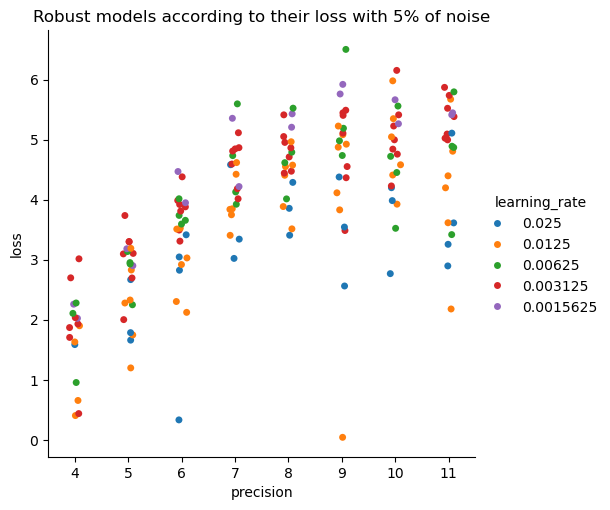

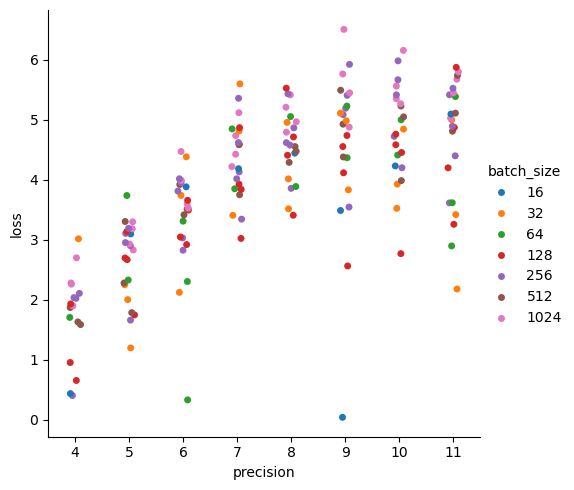

   original_acc      loss batch_size learning_rate  precision
0      0.723607  0.039499         16        0.0125          9
1      0.727575  0.329860         64         0.025          6
2      0.724667  0.402018        256        0.0125          4
3      0.730503  0.435083         16      0.003125          4
4      0.724456  0.653595        128        0.0125          4
     original_acc      loss batch_size learning_rate  precision
169      0.766607  5.869263        128      0.003125         11
170      0.768732  5.919164        256     0.0015625          9
171      0.763453  5.978211        256        0.0125         10
172      0.767376  6.152024       1024      0.003125         10
173      0.767274  6.501803       1024       0.00625          9


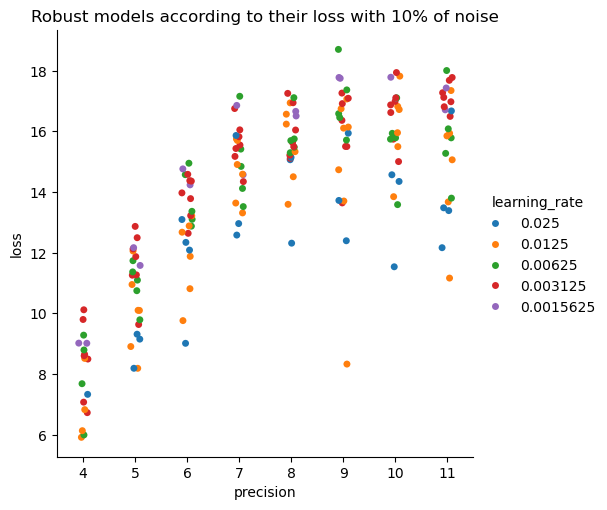

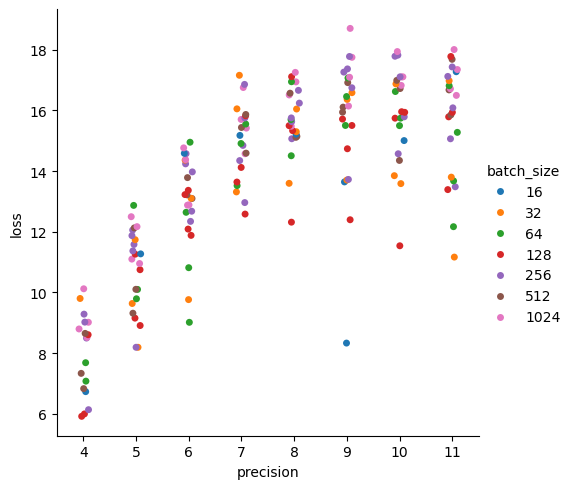

   original_acc      loss batch_size learning_rate  precision
0      0.724456  5.915595        128        0.0125          4
1      0.731738  5.994967        128       0.00625          4
2      0.724667  6.134537        256        0.0125          4
3      0.730503  6.729264         16      0.003125          4
4      0.735757  6.828345        512        0.0125          4
     original_acc       loss batch_size learning_rate  precision
177      0.768859  17.785658        256     0.0015625         10
178      0.763453  17.821866        256        0.0125         10
179      0.767376  17.940033       1024      0.003125         10
180      0.767520  18.007020       1024       0.00625         11
181      0.767274  18.703548       1024       0.00625          9


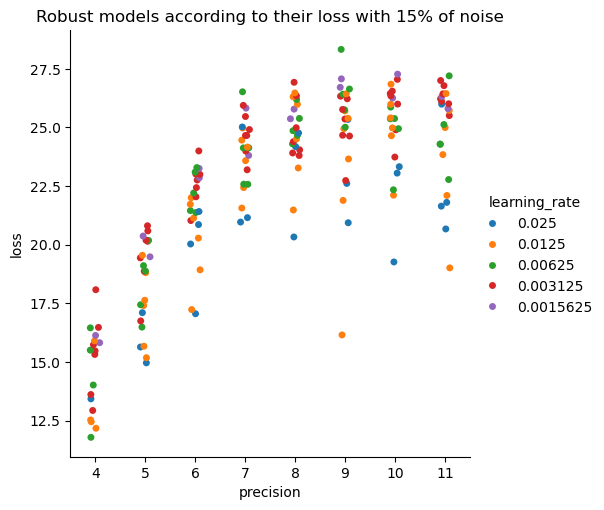

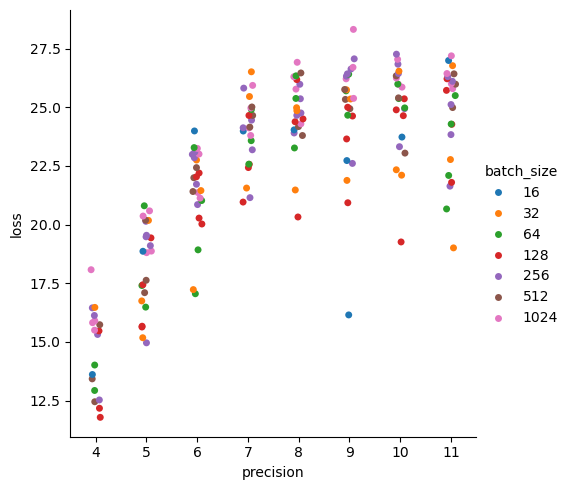

   original_acc       loss batch_size learning_rate  precision
0      0.731738  11.784264        128       0.00625          4
1      0.724456  12.170860        128        0.0125          4
2      0.735757  12.448411        512        0.0125          4
3      0.724667  12.525976        256        0.0125          4
4      0.740774  12.928930         64      0.003125          4
     original_acc       loss batch_size learning_rate  precision
177      0.767376  27.045741       1024      0.003125         10
178      0.768732  27.068722        256     0.0015625          9
179      0.767520  27.196249       1024       0.00625         11
180      0.768859  27.267238        256     0.0015625         10
181      0.767274  28.323641       1024       0.00625          9


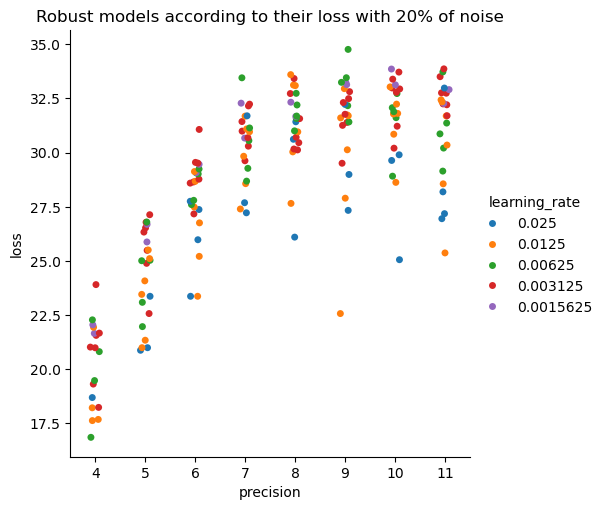

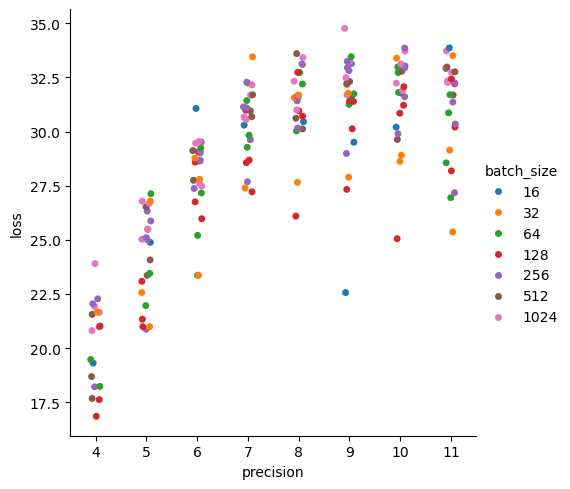

   original_acc       loss batch_size learning_rate  precision
0      0.731738  16.848691        128       0.00625          4
1      0.724456  17.621500        128        0.0125          4
2      0.735757  17.676017        512        0.0125          4
3      0.724667  18.213067        256        0.0125          4
4      0.740774  18.231378         64      0.003125          4
     original_acc       loss batch_size learning_rate  precision
177      0.767376  33.718922       1024      0.003125         10
178      0.767520  33.727567       1024       0.00625         11
179      0.768859  33.860339        256     0.0015625         10
180      0.761423  33.868371         16      0.003125         11
181      0.767274  34.767452       1024       0.00625          9


In [ ]:
noise_levels = [5, 10, 15, 20]
for noise in noise_levels:
    # Check the most robust models per noise
    df = robust_df.drop(robust_df[robust_df.type != f'{noise}%'].index)
    df = df.reset_index()
    
    sns.catplot(df, 
                x='precision', 
                y='loss', 
                hue='learning_rate', 
                order=precisions, 
                hue_order=[str(x) for x in learning_rates])
    plt.title(f'Robust models according to their loss with {noise}% of noise')
    sns.catplot(df, 
                x='precision', 
                y='loss', 
                hue='batch_size', 
                order=precisions, 
                hue_order=[str(x) for x in batch_sizes])
    plt.show()
    print(df[['original_acc', 'loss', 'batch_size', 'learning_rate', 'precision']].head(5))
    print(df[['original_acc', 'loss', 'batch_size', 'learning_rate', 'precision']].tail(5))
    df.to_csv(f"./out_JTAG_{noise}_{noise_type}.csv")

plots of the best models in terms of loss.

In [ ]:
noise = 5 # 5 10 15 20
top_noise_df = robust_df.loc[robust_df.type == f'{noise}%']
top_noise_df = top_noise_df.sort_values(by='loss', ascending=True)
top_noise_df = top_noise_df.reset_index()
top_noise_df.head(5)

,index,precision,accuracy,type,batch_size,learning_rate,loss,original_acc
0,881,9,0.723321,5%,16,0.0125,0.039499,0.723607
1,401,6,0.725175,5%,64,0.025,0.329860,0.727575
2,106,4,0.721754,5%,256,0.0125,0.402018,0.724667
3,16,4,0.727325,5%,16,0.003125,0.435083,0.730503
4,81,4,0.719721,5%,128,0.0125,0.653595,0.724456


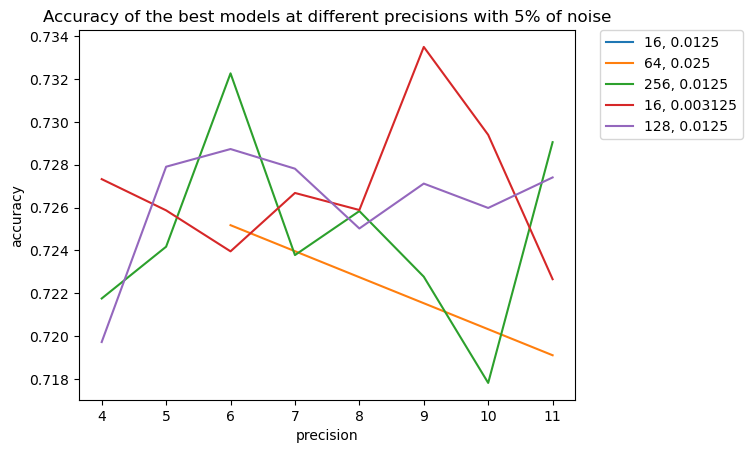

In [ ]:
top_noise_df = top_noise_df.loc[
        (top_noise_df.batch_size == '16') & (top_noise_df.learning_rate == '0.0125') |
        (top_noise_df.batch_size == '64') & (top_noise_df.learning_rate == '0.025') |
        (top_noise_df.batch_size == '256') & (top_noise_df.learning_rate == '0.0125') |
        (top_noise_df.batch_size == '16') & (top_noise_df.learning_rate == '0.003125') |
        (top_noise_df.batch_size == '128') & (top_noise_df.learning_rate == '0.0125')
    ]
hue = top_noise_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_noise_df, x='precision', y='accuracy', hue=hue)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title(f"Accuracy of the best models at different precisions with {noise}% of noise")
plt.show()